In [1]:
# version 1.1

from abc import ABC, abstractmethod, abstractproperty

import numpy as np

##################################################################################################################
# ACTIVATION FUNCTIONS
##################################################################################################################

class Activation(ABC):
    '''
    An abstract class that implements an activation function
    '''

    @abstractmethod
    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the activation function with input x
        :param x: input to activation function
        :return: value of the activation function, with shape x.shape
        '''
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the derivative of the activation function with input x
        :param x: input to activation function
        :return: derivative of the activation function, with shape x.shape
        '''
        pass

class Identity(Activation):
    '''
    Implements the identity activation function (i.e. g(x) = x)
    '''

    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of applying the Identity activation function (i.e. returns the input)
        :param x: input to the activation function
        :return: value of the activation function, with shape x.shape
        '''
        return x

    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the derivative of the identity function with input x (i.e. 1s)
        :param x: input to identity function
        :return: derivative of the activation function, with shape x.shape
        '''
        return np.ones(x.shape)

class Sigmoid(Activation):
    '''
    Implements the sigmoid activation function
    :attr k: Parameter of the sigmoid function that controls its steepness around the origin
    '''

    def __init__(self, k: float=1.):
        '''
        :param k: Parameter of the sigmoid function that controls its steepness around the origin
        '''
        self.k = k
        super(Sigmoid, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the sigmoid function with input x
        :param x: input to sigmoid function
        :return: value of the activation function, with shape x.shape
        '''
        gx = 1 / (1 + np.exp(-self.k * x))
        return gx

    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the derivative of the sigmoid function with input x
        :param x: input to sigmoid function
        :return: derivative of the activation function, with shape x.shape
        '''
        sig = self.value(x)
        dgx = self.k * sig * (1 - sig)
        return dgx


class ReLU(Activation):
    '''
    Implements the rectified linear unit activation function
    '''

    def __init__(self):
        super(ReLU, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the ReLU function with input x
        :param x: input to ReLU function
        :return: value of the activation function, with shape x.shape
        '''
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Returns the result of evaluating the derivative of the ReLU function with input x
        Set the derivative to 0 at x=0.
        :param x: input to ReLU function
        :return: derivative of the activation function, with shape x.shape
        '''
        dx = np.where(x <= 0, 0, 1).astype(float)
        return dx


##################################################################################################################
# LOSS FUNCTIONS
##################################################################################################################

class Loss(ABC):
    '''
    Abstract class for a loss function
    '''

    @abstractmethod
    def value(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        '''
        Computes the value of the loss function for n provided predictions and targets, averaged across n examples
        :param y_hat: Neural network predictions, with shape (n, 1)
        :param y: Targets, with shape (n, 1)
        :return loss: The value of the loss function
        '''
        pass

    @abstractmethod
    def derivative(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        '''
        Computes the derivative of the loss function with respect to the predictions, averaged across n examples
        :param y_hat: Neural network predictions, with shape (n, 1)
        :param y: Targets, with shape (n, 1)
        :return dLdy_hat: The derivative of the loss function with respect to each prediction, with shape (n, 1)
        '''
        pass


class MeanSquaredError(Loss):
    '''
    Implements the mean squared error loss function
    '''

    def value(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        '''
        Computes the mean squared error loss function. Assumes there is only 1 node in the output layer.
        The returned value should be the average loss across the n examples.
        :param y_hat: Neural network predictions, with shape (n, 1)
        :param y: Targets, with shape (n, 1)
        :return loss: The value of the mean squared error loss function
        '''
        loss = np.mean((y_hat - y)**2)
        
        return loss

    def derivative(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        '''
        Computes the derivative of the mean squared error loss function with respect to the predictions. Assumes there
        is only 1 node in the output layer. Returns the partial derivative with respect to each of the n predictions.
        :param y_hat: Neural network predictions, with shape (n, 1)
        :param y: Targets, with shape (n, 1)
        :return dLdy_hat: The derivative of the loss function with respect to each prediction, with shape (n, 1)
        '''
        n = y.shape[0]
        dLdy_hat = 2 * (y_hat - y) / n
        
        return dLdy_hat


##################################################################################################################
# METRICS
##################################################################################################################


def mean_absolute_error(y_hat: np.ndarray, y: np.ndarray) -> float:
    '''
    Computes the mean absolute error between the predictions and the targets. This metric is useful for regression
    problems.
    :param y_hat: Neural network predictions, with shape (n, 1). These should be real numbers.
    :param y: Targets, with shape (n, 1). These should be real numbers.
    :return mae: mean absolute error
    '''
    mae = np.mean(np.abs(y_hat - y))
    
    return mae

In [35]:
# version 1.1

from typing import List
import numpy as np

from operations import *

class NeuralNetwork():
    '''
    A class for a fully connected feedforward neural network (multilayer perceptron).
    :attr n_layers: Number of layers in the network
    :attr activations: A list of Activation objects corresponding to each layer's activation function
    :attr loss: A Loss object corresponding to the loss function used to train the network
    :attr learning_rate: The learning rate
    :attr W: A list of weight matrices. The first row corresponds to the biases.
    '''

    def __init__(self, n_features: int, layer_sizes: List[int], activations: List[Activation], loss: Loss,
                 learning_rate: float=0.01, W_init: List[np.ndarray]=None):
        '''
        Initializes a NeuralNetwork object
        :param n_features: Number of features in each training examples
        :param layer_sizes: A list indicating the number of neurons in each layer
        :param activations: A list of Activation objects corresponding to each layer's activation function
        :param loss: A Loss object corresponding to the loss function used to train the network
        :param learning_rate: The learning rate
        :param W_init: If not None, the network will be initialized with this list of weight matrices
        '''

        sizes = [n_features] + layer_sizes
        if W_init:
            assert all([W_init[i].shape == (sizes[i] + 1, sizes[i+1]) for i in range(len(layer_sizes))]), \
                "Specified sizes for layers do not match sizes of layers in W_init"
        assert len(activations) == len(layer_sizes), \
            "Number of sizes for layers provided does not equal the number of activations provided"

        self.n_layers = len(layer_sizes)
        self.activations = activations
        self.loss = loss
        self.learning_rate = learning_rate
        self.W = []
        for i in range(self.n_layers):
            if W_init:
                self.W.append(W_init[i])
            else:
                rand_weights = np.random.randn(sizes[i], sizes[i+1]) / np.sqrt(sizes[i])
                biases = np.zeros((1, sizes[i+1]))
                self.W.append(np.concatenate([biases, rand_weights], axis=0))

    def forward_pass(self, X) -> (List[np.ndarray], List[np.ndarray]):
        '''
        Executes the forward pass of the network on a dataset of n examples with f features. Inputs are fed into the
        first layer. Each layer computes Z_i = g(A_i) = g(Z_{i-1}W[i]).
        :param X: The training set, with size (n, f)
        :return A_vals: a list of a-values for each example in the dataset. There are n_layers items in the list and
                        each item is an array of size (n, layer_sizes[i])
                Z_vals: a list of z-values for each example in the dataset. There are n_layers items in the list and
                        each item is an array of size (n, layer_sizes[i])
        '''
        
        A_vals = []
        Z_vals = [X]
        
        for i in range(self.n_layers):
            A = np.dot(Z_vals[i], self.W[i][1:]) + self.W[i][0] # A_i = Z_{i-1}W[i] + bias
            Z = self.activations[i].value(A) # Z_i = g(A_i)
            A_vals.append(A)
            Z_vals.append(Z)
            
        return A_vals, Z_vals

    def backward_pass(self, A_vals, dLdyhat) -> List[np.ndarray]:
        '''
        Executes the backward pass of the network on a dataset of n examples with f features. The delta values are
        computed from the end of the network to the front.
        :param A_vals: a list of a-values for each example in the dataset. There are n_layers items in the list and
                       each item is an array of size (n, layer_sizes[i])
        :param dLdyhat: The derivative of the loss with respect to the predictions (y_hat), with shape (n, layer_sizes[-1])
        :return deltas: A list of delta values for each layer. There are n_layers items in the list and
                        each item is an array of size (n, layer_sizes[i])
        '''

        deltas = []
        d = self.activations[-1].derivative(A_vals[-1]) * dLdyhat # output layer
        deltas.append(d)
        
        for i in range(self.n_layers - 2, -1, -1): # rest of the layers
            d = self.activations[i].derivative(A_vals[i]) * np.dot(d, self.W[i+1][1:].T)
            deltas.append(d)
        deltas.reverse()
        return deltas

    def update_weights(self, X, Z_vals, deltas) -> List[np.ndarray]:
        '''
        Having computed the delta values from the backward pass, update each weight with the sum over the training
        examples of the gradient of the loss with respect to the weight.
        :param X: The training set, with size (n, f)
        :param Z_vals: a list of z-values for each example in the dataset. There are n_layers items in the list and
                       each item is an array of size (n, layer_sizes[i])
        :param deltas: A list of delta values for each layer. There are n_layers items in the list and
                       each item is an array of size (n, layer_sizes[i])
        :return W: The newly updated weights (i.e. self.W)
        '''

        n = X.shape[0]
        
        for i in range(self.n_layers):
            bias = np.mean(deltas[i])
            self.W[i][0] -= self.learning_rate * bias
            gradient = np.dot(Z_vals[i].T, deltas[i]) / n
            self.W[i][1:] -= self.learning_rate * gradient
        
        return self.W

    def train(self, X: np.ndarray, y: np.ndarray, epochs: int) -> (List[np.ndarray], List[float]):
        '''
        Trains the neural network model on a labelled dataset.
        :param X: The training set, with size (n, f)
        :param y: The targets for each example, with size (n, 1)
        :param epochs: The number of epochs to train the model
        :return W: The trained weights
                epoch_losses: A list of the training losses in each epoch
        '''

        epoch_losses = []
        for epoch in range(epochs):
            A_vals, Z_vals = self.forward_pass(X)   
            y_hat = Z_vals[-1]                     
            L = self.loss.value(y_hat, y)          
            print("Epoch {}/{}: Loss={}".format(epoch, epochs, L))
            epoch_losses.append(L)                 

            dLdyhat = self.loss.derivative(y_hat, y)        
            deltas = self.backward_pass(A_vals, dLdyhat)    
            self.W = self.update_weights(X, Z_vals, deltas)  

        return self.W, epoch_losses

    def evaluate(self, X: np.ndarray, y: np.ndarray, metric) -> float:
        '''
        Evaluates the model on a labelled dataset
        :param X: The examples to evaluate, with size (n, f)
        :param y: The targets for each example, with size (n, 1)
        :param metric: A function corresponding to the performance metric of choice (e.g. accuracy)
        :return: The value of the performance metric on this dataset
        '''

        A_vals, Z_vals = self.forward_pass(X)      
        y_hat = Z_vals[-1]
        metric_value = metric(y_hat, y)    
        return metric_value



Epoch 0/500: Loss=37.75315567782046
Epoch 1/500: Loss=37.751160730375794
Epoch 2/500: Loss=37.749166113939566
Epoch 3/500: Loss=37.747171806568076
Epoch 4/500: Loss=37.74517780781645
Epoch 5/500: Loss=37.74318411724015
Epoch 6/500: Loss=37.74119073439491
Epoch 7/500: Loss=37.739197658836844
Epoch 8/500: Loss=37.737204890122335
Epoch 9/500: Loss=37.735212430987744
Epoch 10/500: Loss=37.73322029152071
Epoch 11/500: Loss=37.73122845756295
Epoch 12/500: Loss=37.72923692867213
Epoch 13/500: Loss=37.727245704406286
Epoch 14/500: Loss=37.72525478432373
Epoch 15/500: Loss=37.72326416412151
Epoch 16/500: Loss=37.7212737190505
Epoch 17/500: Loss=37.71928329722217
Epoch 18/500: Loss=37.71729314357342
Epoch 19/500: Loss=37.715303292110626
Epoch 20/500: Loss=37.71331374239367
Epoch 21/500: Loss=37.71132449398274
Epoch 22/500: Loss=37.709335546438304
Epoch 23/500: Loss=37.70734689932119
Epoch 24/500: Loss=37.70535855219253
Epoch 25/500: Loss=37.70337045276764
Epoch 26/500: Loss=37.70138222688527
Epo

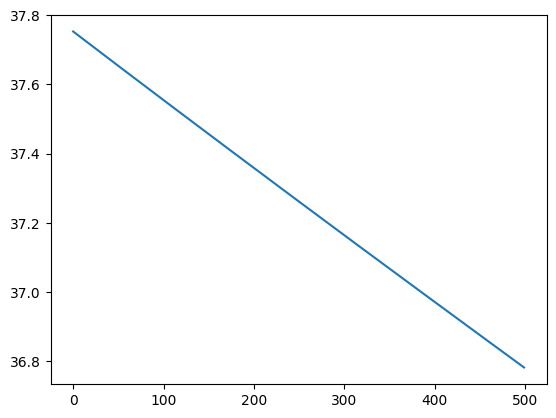

In [36]:
# version 1.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neural_net import NeuralNetwork
from operations import *

def load_dataset(csv_path, target_feature):
    dataset = pd.read_csv(csv_path)
    t = np.expand_dims(dataset[target_feature].to_numpy().astype(float), axis=1)
    X = dataset.drop([target_feature], axis=1).to_numpy()
    return X, t

X, y = load_dataset("data/wine_quality.csv", "quality")

n_features = X.shape[1]
net = NeuralNetwork(n_features, [32,32,16,1], [ReLU(), ReLU(), Sigmoid(), Identity()], MeanSquaredError(), learning_rate=0.001)
epochs = 500

test_split = 0.1
X_train = X[:int((1 - test_split) * X.shape[0])]
X_test = X[int((1 - test_split) * X.shape[0]):]
y_train = y[:int((1 - test_split) * y.shape[0])]
y_test = y[int((1 - test_split) * y.shape[0]):]

trained_W, epoch_losses = net.train(X_train, y_train, epochs)
print("Error on test set: {}".format(net.evaluate(X_test, y_test, mean_absolute_error)))

plt.plot(np.arange(0, epochs), epoch_losses)
plt.show()

Dataset Information:
Total samples: 1599
Number of features: 11
Target range: [3.00, 8.00]
--------------------------------------------------
Info:
Input features: 11
Hidden layers: [64, 32, 16] neurons
Hidden layer activations: ReLU
Output layer: 1 neuron with Identity activation
Loss function: Mean Squared Error
Learning rate: 0.001
Training epochs: 500
--------------------------------------------------
Training Fold 1/5
Training samples: 1280, Validation samples: 319
Epoch 0/500: Loss=29.8863812015557
Epoch 1/500: Loss=29.88537067539856
Epoch 2/500: Loss=29.884360352301645
Epoch 3/500: Loss=29.883350231807917
Epoch 4/500: Loss=29.88234031346168
Epoch 5/500: Loss=29.881330596808574
Epoch 6/500: Loss=29.880321081395586
Epoch 7/500: Loss=29.879311766771032
Epoch 8/500: Loss=29.878302652484575
Epoch 9/500: Loss=29.87729373808718
Epoch 10/500: Loss=29.87628502313114
Epoch 11/500: Loss=29.87527650717007
Epoch 12/500: Loss=29.87426818975889
Epoch 13/500: Loss=29.873260070453814
Epoch 14/50

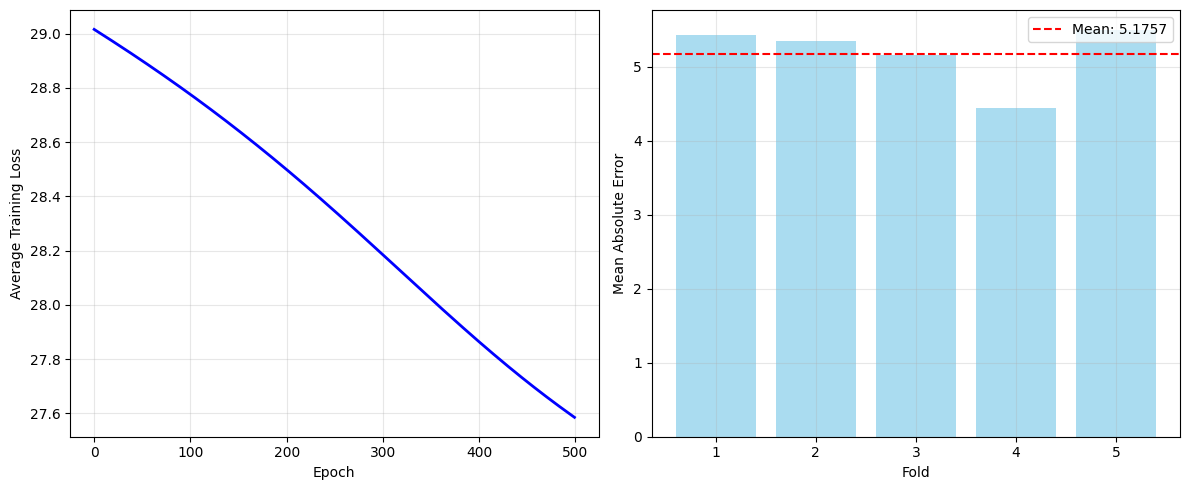


Results
Mean Absolute Error across all folds:
  Average: 5.1757
  Standard Deviation: 0.3835
  Individual fold scores: ['5.4304', '5.3486', '5.1618', '4.4422', '5.4956']

Final average training loss: 27.5858


In [37]:
# k-fold cross validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neural_net import NeuralNetwork
from operations import *

def load_dataset(csv_path, target_feature):
    dataset = pd.read_csv(csv_path)
    t = np.expand_dims(dataset[target_feature].to_numpy().astype(float), axis=1)
    X = dataset.drop([target_feature], axis=1).to_numpy()
    return X, t

def kfold_splits(X, y, k=5, random_seed=42):
    """
    :param X: The examples to evaluate, with size (n, f)
    :param y: The targets for each example, with size (n, 1)
    :param k: number of folds
    :param random_seed: seed for reproducibility
    :returns: List of (X_train, X_val, y_train, y_val) tuples for each fold
    """
    np.random.seed(random_seed)
    n = X.shape[0]
    indices = np.random.permutation(n)
    fold_size = n // k
    
    folds = []
    for i in range(k):
        # calculating validation indices for current fold
        fold_start = i * fold_size # starting index of fold
        fold_end = fold_start + fold_size if i < k - 1 else n  # end index of fold - if it's the very last fold then we go up to the nth index
        fold_indices = indices[fold_start:fold_end]
        
        train_indices = np.concatenate([indices[:fold_start], indices[fold_end:]]) # folds that are not the ith fold (training set)
        
        X_train, X_val = X[train_indices], X[fold_indices]
        y_train, y_val = y[train_indices], y[fold_indices]
        
        folds.append((X_train, X_val, y_train, y_val))
        
    return folds

def kfold_validation(X, y, k=5, epochs=500, learning_rate=0.001):
    """
    :param X: feature matrix (n, f)
    :param y: target vector (n, 1)
    :param k: number of folds
    :param epochs: # of training examples
    :param learning_rate: learning rate
        
    :returns:
        all_losses: List of training losses for each fold
        mae_scores: List of MAE scores for each fold
        avg_losses_per_epoch: Average training loss across folds for each epoch
    """
    n = X.shape[1]
    
    layer_sizes = [64, 32, 16, 1]
    activations = [ReLU(), Sigmoid(), ReLU(), Identity()]
    
    print("Info:")
    print(f"Input features: {n}")
    print(f"Hidden layers: {layer_sizes[:-1]} neurons")
    print(f"Hidden layer activations: ReLU")
    print(f"Output layer: {layer_sizes[-1]} neuron with Identity activation")
    print(f"Loss function: Mean Squared Error")
    print(f"Learning rate: {learning_rate}")
    print(f"Training epochs: {epochs}")
    print("-" * 50)
    
    folds = kfold_splits(X, y, k)
    
    all_losses = []
    maes = []
    
    for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
        print(f"Training Fold {i + 1}/{k}")
        print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
        
        net = NeuralNetwork(n, layer_sizes, activations, MeanSquaredError(),learning_rate)
        
        trained_W, epoch_losses = net.train(X_train, y_train, epochs)
        all_losses.append(epoch_losses)
        
        mae = net.evaluate(X_val, y_val, mean_absolute_error)
        maes.append(mae)
        
        print(f"Fold {i + 1} MAE: {mae:.4f}")
        print("-" * 30)
    
    avg_losses = np.mean(all_losses, axis=0)
    
    return all_losses, maes, avg_losses

def plot_results(avg_losses, maes, epochs=500):

    # avg losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(epochs), avg_losses, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Average Training Loss')
    plt.grid(True, alpha=0.3)

    # mae
    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(maes) + 1), maes, alpha=0.7, color='skyblue')
    plt.axhline(y=np.mean(maes), color='red', linestyle='--', 
                label=f'Mean: {np.mean(maes):.4f}')
    plt.xlabel('Fold')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("Results")
    print("="*60)
    print(f"Mean Absolute Error across all folds:")
    print(f"  Average: {np.mean(maes):.4f}")
    print(f"  Standard Deviation: {np.std(maes):.4f}")
    print(f"  Individual fold scores: {[f'{score:.4f}' for score in maes]}")
    
    print(f"\nFinal average training loss: {avg_losses[-1]:.4f}")


X, y = load_dataset("data/wine_quality.csv", "quality")
    
print("Dataset Information:")
print(f"Total samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")
print("-" * 50)

all_losses, maes, avg_losses = kfold_validation(X, y, k=5, epochs=500, learning_rate=0.001)
plot_results(avg_losses, maes, epochs=500)